# Deep Nerual Network Regression

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
# %matplotlib inline
# %matplotlib qt

 
## Regression Dataset

다음과 같은 regression dataset을 만든다.

* Generate random (x) using `torch.rand` function
    * x should be sampled from uniform distribution of range [-1,1]
    * `y = self.x ** 2 + torch.randn(self.x.size(0))*0.1`

### How to make Dataset
* `torch.utils.data.Dataset`을 상속받는 Class를 정의한다.
  * 다음의 두 method는 필수적으로 정의하여야 한다.
  * `__len__(self)` : Dataset의 크기를 return 한다.
  * `__getitem__(self, idx)` : 데이터셋의 idx번째 데이터를 return 한다.


* `torch.utils.data.DataLoader`에서 Dataset을 받아 데이터를 batch로 만드는 역할을 한다.
  * `enumerate(dataloader)`를 통해 Dataset에 있는 data를 batch 단위로 받아올 수 있다.
  ~~~python
  for batch_idx, data, label in enumerate(trainloader):
        pass
  ~~~


In [13]:
from torch.utils.data import Dataset, DataLoader

# define dataset class
# __getitem__ returns tensors of shape (1,), (1,)
# TODO
class RegressionDataset(Dataset):
    def __init__(self, num_data = 5000):
        super().__init__()
        self.x = (torch.rand(num_data, 1) -0.5)/0.5 # [-1, 1]   마이너스1 나누기 2해도 똑같음   0 ~ 1
#         self.y = self.x ** 2 + torch.randn(self.x.size(0), 1) * 0.1
        self.y = self.x ** 2 + torch.randn(self.x.size()) * 0.1

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, idx):
#         return self.x[idx, None], self.y[idx, None] # None : Unsqueeze됨
        return self.x[idx], self.y[idx]


# crate dataset
# train: 5000 data points
# test: 1000 data points
# TODO
train_data = RegressionDataset(5000)
test_data = RegressionDataset(1000)

In [14]:
# Test case
#  - check the size of dataset
assert len(train_data) == 5000, "The length of training set should be 5000."
assert len(test_data) == 1000, "The length of test set should be 1000."
x, y = train_data[0]
assert tuple(x.shape) == (1,), 'The input shape should be (1,). Actual: ' + str(x.shape)
assert tuple(y.shape) == (1,),'The output shape should be (1,). Actual: ' + str(y.shape)

In [15]:
# create DataLoader
# train: batch size = 32
# test: batch size = 1

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

### Visualize Dataset

<ipython-input-16-ec26bcd2b59d>:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(x, y, 's', markersize=3, marker='o')


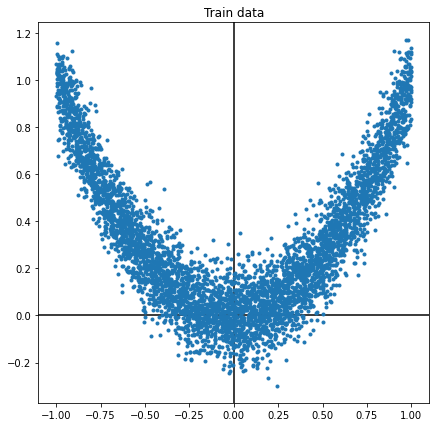

In [16]:
input_list = []
output_list = []
for x, y in train_data:
    input_list.append(x)
    output_list.append(y)
x = np.array(input_list)
y = np.array(output_list)

plt.figure(figsize=(7, 7))
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title('Train data')

plt.plot(x, y, 's', markersize=3, marker='o')
plt.show()

## Single layer neural network
* Single layer neural network
    * Fully connected layer - in_features: 1, out_features: 1


In [17]:
# TODO
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.fc1(x)

### Train the network on the training data

#### Define a Loss function and optimizer
* Use Mean Squared Error loss
* Use SGD with learning rate 0.01 and momentum 0.5

In [18]:
# define a loss and optimizer
# TODO
loss_obj = nn.MSELoss()

def create_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    return optimizer

#### Define training loop

In [29]:
def train(model, num_epochs, loss_obj):
    model.train()
    optimizer = create_optimizer(model)
    for epoch in range(num_epochs):
        for batch_idx, (input, target) in enumerate(train_loader):
            # input and target to cpu
            input, target = input.to(device), target.to(device)

            # forward model
            output = model(input)
            
            # compute loss
            loss = loss_obj(output, target)
            
            # zero_grad -> backward() -> step()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print('\r[Epoch {}/{}][itr {}/{}] Loss: {}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss), end='')

In [30]:
# train the netwok
# num_epochs=10
# TODO
model_single_ann = ANN().to(device)
train(model_single_ann, 10, loss_obj)

[Epoch 10/10][itr 157/157] Loss: 0.082936599850654685

### Define test loop

In [31]:
def test(model, loss_obj):
    model.eval()
    test_loss = 0
    px = []
    py = []

    for input, target in test_loader:
        input, target = input.to(device), target.to(device)
        with torch.no_grad():
            output = model(input)
        test_loss += loss_obj(output, target).cpu().item() # sum up batch loss

        px.append(input.cpu().numpy())
        py.append(output.cpu().detach().numpy())

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))

    px = np.array(px)[:,0,0]
    py = np.array(py)[:,0,0]
    return px, py

### Test the network on the test data


Test set: Average loss: 0.0995



<ipython-input-32-1294eca0b7f2>:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(px, py, 's', markersize=3, marker='o')


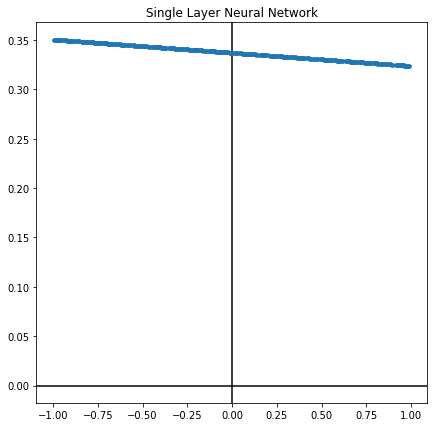

In [32]:
# test the network
# TODO
px, py = test(model_single_ann, loss_obj)

# visualize
def visualize_output(px, py, title=''):
    plt.figure(figsize=(7, 7))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.title(title)

    plt.plot(px, py, 's', markersize=3, marker='o')

visualize_output(px, py, 'Single Layer Neural Network')

## Sigmoid DNN
* Sigmoid DNN
    * Fully connected layer - in_features: 1, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 1
    * Apply Sigmoid activation function for hidden layers.


In [44]:
# TODO
class SigmoidDNN(nn.Module):
    def __init__(self):
        super(SigmoidDNN, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Train the network on the training data

In [45]:
## todo
model_sigmoid_dnn = SigmoidDNN().to(device)
train(model_sigmoid_dnn, 10, loss_obj)

/home/piai/anaconda3/envs/abc/lib/python3.8/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Epoch 10/10][itr 157/157] Loss: 0.12648627161979675

### Test the network on the test data


Test set: Average loss: 0.0994



<ipython-input-32-1294eca0b7f2>:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(px, py, 's', markersize=3, marker='o')


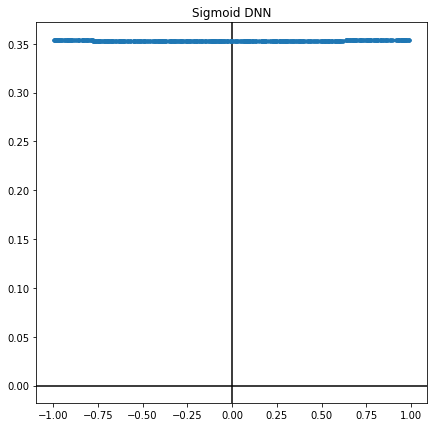

In [46]:
predict_true, predict_false = test(model_sigmoid_dnn, loss_obj)

visualize_output(predict_true, predict_false, 'Sigmoid DNN')

## ReLU DNN
* ReLU
    * Fully connected layer - in_features: 1, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 1
    * Apply ReLU activation function for hidden layers.

In [39]:
# TODO
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Train the network on the training data

In [41]:
model_dnn = DNN().to(device)
train(model_dnn, 10, loss_obj)

from pathlib import Path
Path('./ckpt').mkdir(exist_ok=True)
torch.save(model_dnn.state_dict(), './ckpt/model_dnn.ckpt') # 학습된 모델 저장하기

[Epoch 10/10][itr 157/157] Loss: 0.017917428165674215

### Test the network on the test data


Test set: Average loss: 0.0116



<ipython-input-32-1294eca0b7f2>:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(px, py, 's', markersize=3, marker='o')


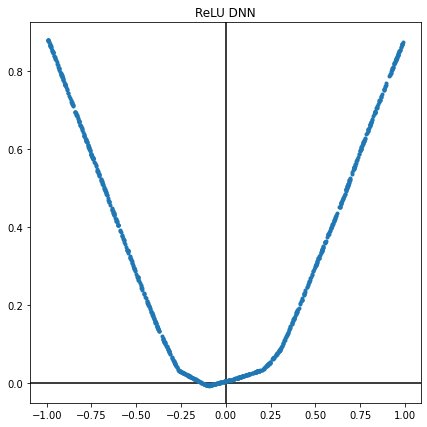

In [43]:
net = DNN().to(torch.device('cuda'))
net.load_state_dict(torch.load('./ckpt/model_dnn.ckpt')) # 저장된 chpt 불러오기

predict_true, predict_false = test(net, loss_obj)

visualize_output(predict_true, predict_false, 'ReLU DNN')